# Green technology: From grants to patents

## Theory of change

Places with larger networks (as represented by a larger number of PIs) would be more innovative (produce more patents with a given amount of funding) than places with smaller networks (where there are fewer opportunities for diffusion of knowledge).

Our unit of analysis is places.

## Analysis outline

We defining our outcome of interest as the number of patents produced within a given city as a function of the number of PIs (and associated researchers) and the dollar amount of grants received.

The data will be linked between the grants and patents via the PI name (or other project members) and the organization. Data will be summarized on the city level. A regression wil be run on the above variables.

## Set up

In [1]:
# os tools
import glob as glob
import os
import openpyxl

# data manipulation
import pandas as pd
import numpy as np

# record linkage
from recordlinkage.preprocessing import clean, phonetic

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
from nltk.corpus import stopwords
import string

# for plotting
from plotnine import * 
theme_set(theme_minimal())

# for regression
import statsmodels.formula.api as sm

# show all columns when printing dataframe
pd.set_option('display.max_columns', None)

# set working directory
%cd "/home/joemarlo/Dropbox/School/NYU/2021_Spring/PADMGP2505_BigData"

/home/joemarlo/Dropbox/School/NYU/2021_Spring/PADMGP2505_BigData


## Identifying green technology grants

We identify green technology grants via a keyword search. We first define a list of green technology specific words developed from X,Y,Z research.

In [2]:
# create list of green keywords
green_keywords = ['green technology', 'renewable', 'sustainable', 'wind energy', 'wind turbine', 'solar energy', 'solar panel', 'photovoltaic', 'cap-and-trade', 'carbon neutral', 'carbon offset', 'carbon credit', 'carbon emissions', 'fossil fuels', 'greenhouse gas', 'greenhouse effect', 'energy star', 'biodegradable', 'co2', 'carbon dioxide', 'recyclable', 'recycling', "environmentally sound technology", "climate smart", "climate friendly", "low carbon", "energy efficiency", "resource efficiency", "end of pipe technology", "so2", "command and control", "control standards", "sustainable building", "building performance technology", "electric vehicle", "recycling technology", "water purification", "eco-design", "low waste", "environmentally conscious", "climate change adaptation", "concentrated solar power", "thermal storage", "offshore wind", "geothermal technology", "fuel cell", "grid energy storage", "smart grid technology"]
green_keywords_regex = "|".join(green_keywords)

In [ ]:
# read in the data and filter to just green tech 
all_abstracts = glob.glob("data/abstracts/*.csv")
all_abstracts.sort()

green_abstracts = []

for abstract_file in all_abstracts:
    
    # read in abstract data
    abstract_df = pd.read_csv(abstract_file, index_col=None, header=0, skipinitialspace=True)
    abstract_df.columns = abstract_df.columns.str.lower()
    
    # add unique id as project_id is only unique to the year
    year = abstract_file[-8:][:4]
    year = np.repeat(np.array([year]), len(abstract_df))
    abstract_df['id'] = abstract_df.project_id.astype('str').str.cat(year, sep = '_')
    
    # find the green patents by searching for keywords in the grant abstract
    matching_rows = abstract_df.abstract.str.contains(green_keywords_regex, case=False, regex=True)
    abstract_green_df = abstract_df[matching_rows.fillna(False)]
    
    # append it to the results list
    green_abstracts.append(abstract_green_df)


# combine into one dataframe
abstracts_df = pd.concat(green_abstracts, axis=0, ignore_index=True)

In [5]:
### write out for later use
abstracts_df.to_csv('data/green_abstracts.csv', index=False)
# abstracts_df = pd.read_csv('data/green_abstracts.csv', index_col=None)

We're going to create a single dataframe of all of the grants with key data that we will use for linkage.

In [56]:
# read in the data and filter to just green tech 
all_grants = glob.glob("data/projects/*.csv")
all_grants.sort()

green_grants = []

for grant_file in all_grants:
    
    # read in the grant data
    grant_df = pd.read_csv(grant_file, index_col=None, header=0, skipinitialspace=True,
                           usecols=['PROJECT_ID', 'PROJECT_START_DATE', 'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'ORGANIZATION_NAME', 'ORGANIZATION_CITY', 'ORGANIZATION_STATE', 'ORGANIZATION_COUNTRY', 'ORGANIZATION_ZIP', 'FY_TOTAL_COST'])
    grant_df.columns = grant_df.columns.str.lower()
    
    # add unique id as project_id is only unique to the year
    year = grant_file[-8:][:4]
    year = np.repeat(np.array([year]), len(grant_df))
    grant_df['id'] = grant_df.project_id.astype('str').str.cat(year, sep = '_')
    
    # subset to just grants we identified as "green tech"
    grant_df = grant_df[grant_df.id.isin(abstracts_df.id)]
    
    # append it to the results list
    green_grants.append(grant_df)


# combine into one dataframe
grants_df = pd.concat(green_grants, axis=0, ignore_index=True)

In [14]:
# write out for later use
grants_df.to_csv('data/green_grants.csv', index=False)
# grants_df = pd.read_csv('data/green_grants.csv', index_col=None)

In [15]:
grants_df.head()

,project_id,project_start_date,contact_pi_project_leader,other_pis,organization_name,organization_city,organization_state,organization_zip,organization_country,fy_total_cost,id
0,121222,10/1/2010,"GUILDERSON, THOMAS P",NaN,UNIVERSITY OF CALIFORNIA SANTA CRUZ,SANTA CRUZ,CA,95064-4107,UNITED STATES,78594.0,121222_2010
1,121225,7/16/2010,"ZHANG, WEI",NaN,VIRGINIA COMMONWEALTH UNIVERSITY,RICHMOND,VA,23298-0568,UNITED STATES,272164.0,121225_2010
2,121237,10/1/2010,"CHARLES, CHRISTOPHER D",NaN,UNIVERSITY OF CALIFORNIA SAN DIEGO,LA JOLLA,CA,92093-0210,UNITED STATES,160815.0,121237_2010
3,121239,12/1/2010,"KUMAR, ASHOK","RAM, MANOJ",UNIVERSITY OF SOUTH FLORIDA,TAMPA,FL,33612-9446,UNITED STATES,231305.0,121239_2010
4,121241,10/1/2010,"SEAMES, WAYNE S","GJOVIG, BRUCE",UNIVERSITY OF NORTH DAKOTA,GRAND FORKS,ND,58202-0000,UNITED STATES,99000.0,121241_2010


We should have the same number of grants as we did abstracts and there should be no duplicates.

In [19]:
len(grants_df.id.unique()) == len(grants_df.id) == len(abstracts_df.id.unique()) == len(abstracts_df.id)

True

In [20]:
# add year column
grants_df['year'] = grants_df.id.apply(lambda x: x[-4:])

# remove non-US locations
grants_df = grants_df[grants_df.organization_country == 'UNITED STATES']

# ensure date column is type date
grants_df['project_start_date'] = pd.to_datetime(grants_df.project_start_date)

# trim zip to just first five digits (for later matching)
grants_df['organization_zip'] = grants_df.organization_zip.apply(lambda x: str(x)[0:5])
grants_df = grants_df.rename(columns={'organization_zip': 'ZIP'})

### How many green grants did we identify?

In [21]:
print("We identified " + str(len(grants_df)) + " grants or " + str(round((len(abstracts_df) / 822554) * 100, 2)) + "% of all grants in our data.")

We identified 30274 grants or 3.79% of all grants in our data.


### How are the grants distributed across the years?

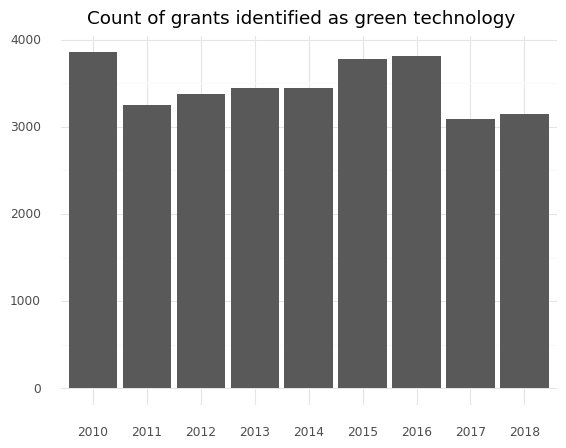

<ggplot: (8781645818534)>

In [22]:
grants_by_year = abstracts_df.id.apply(lambda x: x[-4:]).value_counts().reset_index()
(ggplot(grants_by_year) +
 aes(x='index', y='id') +
 geom_col() +
 labs(title='Count of grants identified as green technology',
           x=None,
           y=None)
)

### Which states are these grants located in?

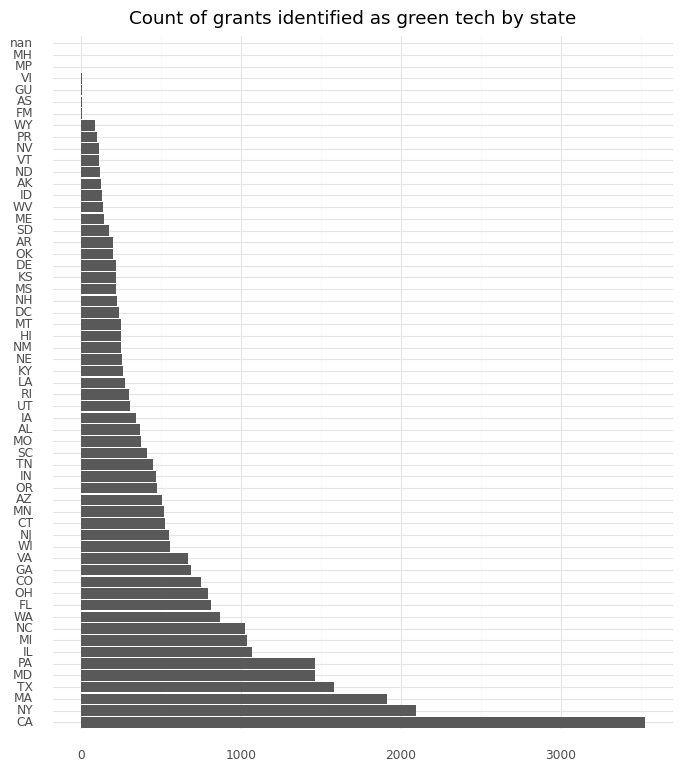

<ggplot: (8781640545964)>

In [23]:
# count grants by state
grants_by_state = grants_df.copy(deep=True)
states_ordered = grants_by_state['organization_state'].value_counts().index.tolist()
grants_by_state = grants_by_state.assign(state = pd.Categorical(grants_by_state['organization_state'], categories=states_ordered))
(ggplot(grants_by_state) +
 aes(x='state') +
 geom_bar() +
 coord_flip() +
 labs(title='Count of grants identified as green tech by state',
           x=None,
           y=None) +
 theme(figure_size=(8, 9))
)

### Who are the top institutions and PIs?

In [24]:
grants_by_state.contact_pi_project_leader.value_counts().reset_index().head(10)

,index,contact_pi_project_leader
0,"BRADY, KATHLEEN T.",27
1,"HYDER, ADNAN A",26
2,"ALBERT, MARILYN S",26
3,"LANGER, ROBERT SAMUEL",22
4,"DELP, SCOTT L",22
5,"ROSEN, STEVEN T.",22
6,"HALTERMAN, JILL S",19
7,"BECKER, DONALD F",19
8,"SANDERS, KENTON M",19
9,"ALEXANDER, SUSAN",18


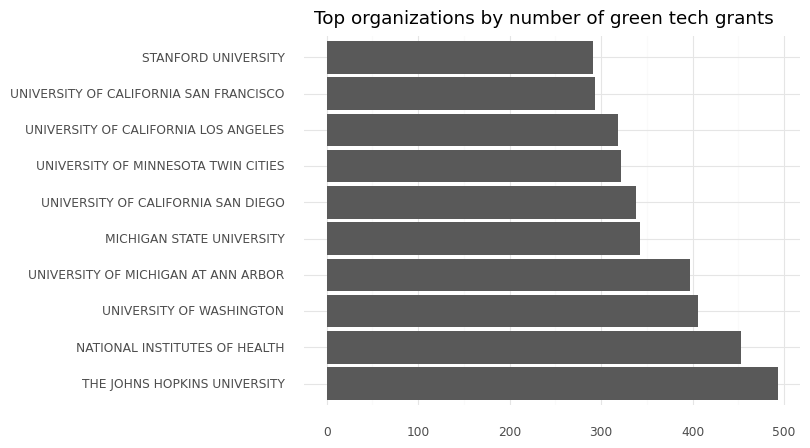

<ggplot: (8781640546018)>

In [25]:
top_orgs = grants_by_state.organization_name.value_counts().reset_index().head(10)
top_orgs_list = grants_by_state.organization_name.value_counts().head(10).index.tolist()
top_orgs = top_orgs.assign(org = pd.Categorical(top_orgs['index'], categories=top_orgs_list))
(ggplot(top_orgs, aes(x='org', y='organization_name')) +
    geom_col() +
    coord_flip() +
    labs(title='Top organizations by number of green tech grants',
         x=None,
         y=None)
)

Since there can be multiple PIs in `other_pis` we need to unnest this data. We'll create as additional row for each additional PI on a grant. Previously each row was a grant; after this conversion grants should be counted by `project_id`.

In [26]:
# first separate other_pis into a list of the names
grants_df.other_pis = grants_df.other_pis.fillna("")
grants_df['all_pis'] = grants_df.other_pis.apply(lambda x: x.split("; "))

# add primary pi to this new list
for pi, pis in zip(grants_df.contact_pi_project_leader, grants_df.all_pis):
    pis.append(pi)

In [27]:
# explode the list into rows
grants_df = grants_df.explode("all_pis")

# remove duplicates caused by "" NA replacement
grants_df = grants_df[grants_df.all_pis != ""]

In [28]:
grants_df.head(10)

,project_id,project_start_date,contact_pi_project_leader,other_pis,organization_name,organization_city,organization_state,ZIP,organization_country,fy_total_cost,id,year,all_pis
0,121222,2010-10-01,"GUILDERSON, THOMAS P",,UNIVERSITY OF CALIFORNIA SANTA CRUZ,SANTA CRUZ,CA,95064,UNITED STATES,78594.0,121222_2010,2010,"GUILDERSON, THOMAS P"
1,121225,2010-07-16,"ZHANG, WEI",,VIRGINIA COMMONWEALTH UNIVERSITY,RICHMOND,VA,23298,UNITED STATES,272164.0,121225_2010,2010,"ZHANG, WEI"
2,121237,2010-10-01,"CHARLES, CHRISTOPHER D",,UNIVERSITY OF CALIFORNIA SAN DIEGO,LA JOLLA,CA,92093,UNITED STATES,160815.0,121237_2010,2010,"CHARLES, CHRISTOPHER D"
3,121239,2010-12-01,"KUMAR, ASHOK","RAM, MANOJ",UNIVERSITY OF SOUTH FLORIDA,TAMPA,FL,33612,UNITED STATES,231305.0,121239_2010,2010,"RAM, MANOJ"
3,121239,2010-12-01,"KUMAR, ASHOK","RAM, MANOJ",UNIVERSITY OF SOUTH FLORIDA,TAMPA,FL,33612,UNITED STATES,231305.0,121239_2010,2010,"KUMAR, ASHOK"
4,121241,2010-10-01,"SEAMES, WAYNE S","GJOVIG, BRUCE",UNIVERSITY OF NORTH DAKOTA,GRAND FORKS,ND,58202,UNITED STATES,99000.0,121241_2010,2010,"GJOVIG, BRUCE"
4,121241,2010-10-01,"SEAMES, WAYNE S","GJOVIG, BRUCE",UNIVERSITY OF NORTH DAKOTA,GRAND FORKS,ND,58202,UNITED STATES,99000.0,121241_2010,2010,"SEAMES, WAYNE S"
5,121248,2010-10-01,"EHLIG-ECONOMIDES, CHRISTINE A","YALVAC, BUGRAHAN",TEXAS ENGINEERING EXPERIMENT STATION,COLLEGE STATION,TX,77843,UNITED STATES,320647.0,121248_2010,2010,"YALVAC, BUGRAHAN"
5,121248,2010-10-01,"EHLIG-ECONOMIDES, CHRISTINE A","YALVAC, BUGRAHAN",TEXAS ENGINEERING EXPERIMENT STATION,COLLEGE STATION,TX,77843,UNITED STATES,320647.0,121248_2010,2010,"EHLIG-ECONOMIDES, CHRISTINE A"
6,121252,2010-10-01,"SHAKOURI, ALI","DUPUIS, MELANIE; GLIESSMAN, STEPHEN; ISAACSON,...",UNIVERSITY OF CALIFORNIA SANTA CRUZ,SANTA CRUZ,CA,95064,UNITED STATES,461686.0,121252_2010,2010,"DUPUIS, MELANIE"


## Linking the grants to patents

Grants will be linked to patents based on the PI name (or name of contributors) and the organization name

In [29]:
# read in the patents data
all_patents = glob.glob("data/patents/*.csv")
all_patents.sort()

patents = []

for patent_file in all_patents:
    
    # read in abstract data
    patent_df = pd.read_csv(patent_file, index_col=None, header=0, skipinitialspace=True)
    patent_df.columns = patent_df.columns.str.lower()
    
    # append it to the results list
    patents.append(patent_df)


# combine into one dataframe
patents_df = pd.concat(patents, axis=0, ignore_index=True)

### Pre-processing

In [30]:
# ensure date column is type date
patents_df['app_date'] = pd.to_datetime(patents_df.app_date)
patents_df['patent_date'] = pd.to_datetime(patents_df.patent_date)

# remove patents with application dates before 2010 (since our grants data starts in 2010)
patents_df = patents_df[patents_df.app_date >= '2010-01-01']

# rename columns to shorter names
patents_df = patents_df.rename(columns={'patent_firstnamed_inventor_name_first': 'name_first',
                           'patent_firstnamed_inventor_name_last': 'name_last',
                           'patent_firstnamed_inventor_city': 'inventor_city',
                           'patent_firstnamed_inventor_state': 'inventor_state',
                           'patent_firstnamed_inventor_latitude': 'inventory_lat',
                           'patent_firstnamed_inventor_longitude': 'inventory_long',
                           'patent_firstnamed_assignee_organization': 'organization',
                           'patent_firstnamed_assignee_city': 'organization_city',
                           'patent_firstnamed_assignee_state': 'organization_state',
                           'patent_firstnamed_assignee_latitude': 'organization_lat',
                           'patent_firstnamed_assignee_longitude': 'organization_long'})

In [31]:
# drop unneccessary columns
grants_df = grants_df.drop(columns=['organization_country', 'contact_pi_project_leader', 'other_pis'])

# rename columns to shorter names
grants_df = grants_df.rename(columns={'all_pis': 'name',
                                      'organization_name': 'organization',
                                      'organization_state': 'state',
                                      'organization_city': 'city',
                                      'fy_total_cost': 'grant_cost'})

In [32]:
# split name into first, middle, last
grants_df['name_first'] = grants_df['name'].str.split(' ').str.get(1)
grants_df['name_last'] = grants_df['name'].str.split(' ').str.get(0)
grants_df['name_middle'] = grants_df['name'].str.split(' ').str.get(2)

patents_df['name_middle'] = patents_df['name_first'].str.split(' ').str.get(1)
patents_df['name_first'] = patents_df['name_first'].str.split(' ').str.get(0)

In [33]:
# clean all columns that contain names
grants_df['name_last'] = clean(grants_df['name_last'])
grants_df['name_first'] = clean(grants_df['name_first'])
grants_df['name_middle'] = clean(grants_df['name_middle'])
grants_df['organization'] = clean(grants_df['organization'])
grants_df['state'] = clean(grants_df['state'])
grants_df['city'] = clean(grants_df['city'])

patents_df['name_last'] = clean(patents_df['name_last'])
patents_df['name_middle'] = clean(patents_df['name_middle'])
patents_df['name_first'] = clean(patents_df['name_first'])
patents_df['inventor_city'] = clean(patents_df['inventor_city'])
patents_df['inventor_state'] = clean(patents_df['inventor_state'])
patents_df['organization'] = clean(patents_df['organization'])
patents_df['organization_state'] = clean(patents_df['organization_state'])
patents_df['organization_city'] = clean(patents_df['organization_city'])

We're going to match on phoentic names so we first need to convert all names to their phoentic name.

In [34]:
# add phoentic names
grants_df["phonetic_first"] = phonetic(grants_df["name_first"], method="nysiis")
grants_df["phonetic_last"] = phonetic(grants_df["name_last"], method="nysiis")
grants_df["phonetic_middle"] = phonetic(grants_df["name_middle"], method="nysiis")
grants_df["phonetic_organization"] = phonetic(grants_df["organization"], method="nysiis")
grants_df["phonetic_state"] = phonetic(grants_df["state"], method="nysiis")
grants_df["phonetic_city"] = phonetic(grants_df["city"], method="nysiis")

patents_df["phonetic_first"] = phonetic(patents_df["name_first"], method="nysiis")
patents_df["phonetic_last"] = phonetic(patents_df["name_last"], method="nysiis")
patents_df["phonetic_middle"] = phonetic(patents_df["name_middle"], method="nysiis")
patents_df["phonetic_organization"] = phonetic(patents_df["organization"], method="nysiis")
patents_df["phonetic_state"] = phonetic(patents_df["organization_state"], method="nysiis")
patents_df["phonetic_city"] = phonetic(patents_df["organization_city"], method="nysiis")

We're matching on the PI name and the organization so we will merge on their phoentic equavalents.

In [35]:
# merge on phonetic name and organization
matched_projects_df = grants_df.merge(patents_df,
                                      on=['phonetic_first','phonetic_last','phonetic_organization'],
                                      suffixes=('_grants', '_patents'))

In [36]:
# remove matches where the patent application comes before grant start date + 1 year
matched_projects_df = matched_projects_df[matched_projects_df.app_date >= (matched_projects_df.project_start_date + pd.offsets.DateOffset(years=1))]

In [37]:
# remove duplicate matches due to multiple pis
# I don't think this is neccessary because there is only one name on the patent
matched_projects_df = matched_projects_df.drop_duplicates(subset=['id', 'patent_number'])

### How many matched projects do we have?

In [38]:
len(matched_projects_df)

1417

### How many unique PIs are there?

In [39]:
matched_projects_df.name.nunique()

366

### What cities are the most popular?
We're considering that the city from the grants data is the proper city. They do not always perfectly match; the patent data seems more specific while the grants data is the metropolitan area.

In [40]:
# create new column denoting the city and state
matched_projects_df['city_state'] = matched_projects_df.city.apply(lambda x: x.title()) + ", " + matched_projects_df.state.apply(lambda x: x.upper())

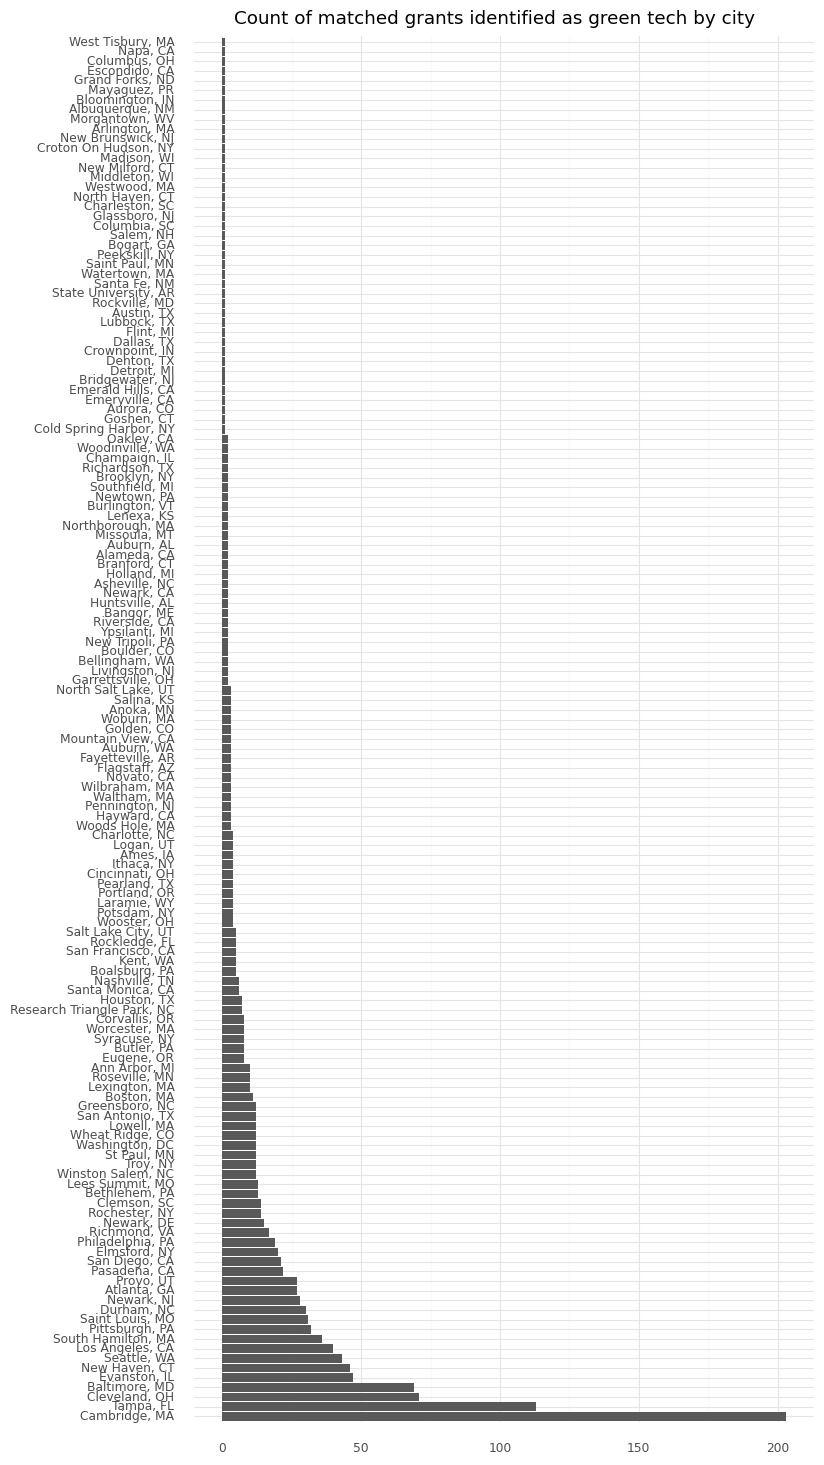

<ggplot: (8781645316374)>

In [41]:
# plot the count of cities
cities_ordered = matched_projects_df['city_state'].value_counts().index.tolist()
matched_by_city = matched_projects_df.assign(city_state = pd.Categorical(matched_projects_df['city_state'], categories=cities_ordered))
(ggplot(matched_by_city) +
 aes(x='city_state') +
 geom_bar() +
 coord_flip() +
 labs(title='Count of matched grants identified as green tech by city',
           x=None,
           y=None) +
 theme(figure_size=(8, 18))
)

In [42]:
# create a dataframe of the patent counts; this contains only matched patents
count_of_matched_patents_by_city = matched_projects_df.city_state.value_counts()
count_of_matched_patents_by_city = pd.DataFrame(count_of_matched_patents_by_city).reset_index().rename(columns={'index': 'city', 'city_state': 'n_patents'})
count_of_matched_patents_by_city

,city,n_patents
0,"Cambridge, MA",203
1,"Tampa, FL",113
2,"Cleveland, OH",71
3,"Baltimore, MD",69
4,"Evanston, IL",47
...,...,...
138,"Grand Forks, ND",1
139,"Escondido, CA",1
140,"Columbus, OH",1
141,"Napa, CA",1


## Number of PIs by city
We're going to count the PIs and funding over the entire time period. Ideally, these PI counts and the funding would be distributed over time. E.g. if matched patent X occurs t+1 then the relevant PI count would be in t+0.

In [43]:
# create a dataframe of counts of unique pis by city; includes all pis, not just matched
grants_df['city_state'] = grants_df.city.apply(lambda x: str(x).title()) + ", " + grants_df.state.apply(lambda x: str(x).upper())
count_of_pis_by_city = grants_df[['city_state', 'name']].drop_duplicates().city_state.value_counts()
count_of_pis_by_city = pd.DataFrame(count_of_pis_by_city).reset_index().rename(columns={'index': 'city', 'city_state': 'n_pis'})
count_of_pis_by_city

,city,n_pis
0,"New York, NY",577
1,"East Lansing, MI",538
2,"Madison, WI",457
3,"Boston, MA",452
4,"Gainesville, FL",443
...,...,...
1131,"Cold Spring, NY",1
1132,"Cedar Park, TX",1
1133,"Niles, IL",1
1134,"Rochester Hills, MI",1


## Funding by city

In [44]:
# create a dataframe of funding by city; includes all funding, not just matched
funding_by_city = grants_df[['city_state', 'grant_cost']].drop_duplicates().groupby('city_state').sum()
funding_by_city = pd.DataFrame(funding_by_city).reset_index().rename(columns={'city_state': 'city'})
funding_by_city.sort_values('grant_cost', ascending=False)

,city,grant_cost
77,"Behtesda, MD",643603992.0
721,"New York, NY",341316346.0
106,"Boston, MA",298834077.0
63,"Baltimore, MD",246643055.0
931,"Seattle, WA",241121736.0
...,...,...
564,"Lee, NH",0.0
537,"Lac Du Flambeau, WI",0.0
532,"Kolonia Pohnpei, FM",0.0
821,"Pomfret Center, CT",0.0


## Final dataset

Create the final dataset consisting of each city, the number of pis, the amount of funding, and the resulting patents

In [125]:
# merge the funding, pi, and patent dataframe into one
city_summary = count_of_pis_by_city.merge(funding_by_city, on='city').merge(count_of_matched_patents_by_city, on='city', how='left').fillna(0)
city_summary.to_csv('data/city_summary.csv', index=False)
city_summary.sort_values('n_patents', ascending=False).reset_index()

,index,city,n_pis,grant_cost,n_patents
0,21,"Cambridge, MA",320,138820655.0,203.0
1,82,"Tampa, FL",110,29717421.0,113.0
2,76,"Cleveland, OH",116,91114989.0,71.0
3,23,"Baltimore, MD",310,246643055.0,69.0
4,67,"Evanston, IL",129,33886488.0,47.0
...,...,...,...,...,...
1131,445,"Scotts Valley, CA",5,1813192.0,0.0
1132,446,"Alexandria, VA",5,550199.0,0.0
1133,447,"Georgetown, TX",5,614325.0,0.0
1134,448,"Daytona Beach, FL",5,659914.0,0.0


## EDA

/home/joemarlo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


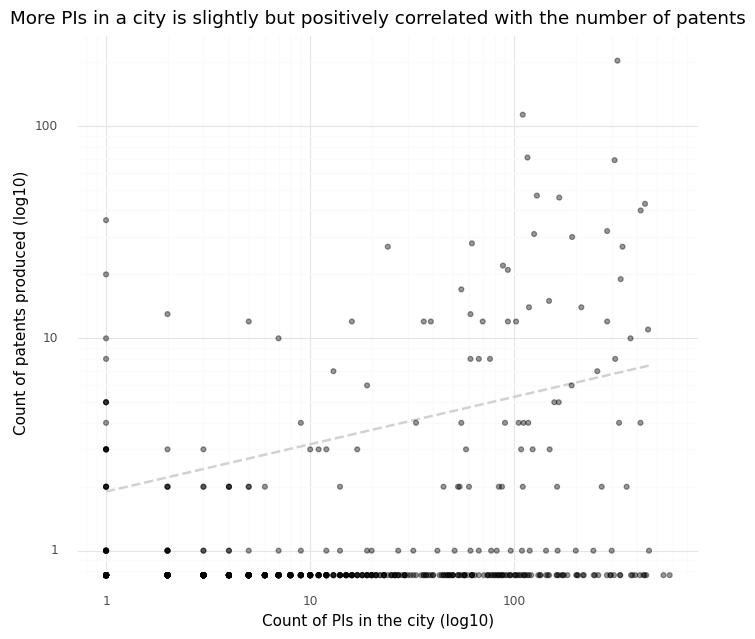

In [126]:
fig = (ggplot(city_summary,
        aes(x='n_pis', y='n_patents')) +
        geom_smooth(method='lm', se=False, linetype='dashed', color='#d1d1d1') +
        geom_point(alpha = 0.4) +
        scale_x_log10() +
        scale_y_log10() +
        labs(title="More PIs in a city is slightly but positively correlated with the number of patents",
             x='Count of PIs in the city (log10)',
             y='Count of patents produced (log10)') +
        theme(figure_size=(8, 7))
    ).draw()
ax = fig.axes[0]
ax.collections[0].set_clip_on(False)

/home/joemarlo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


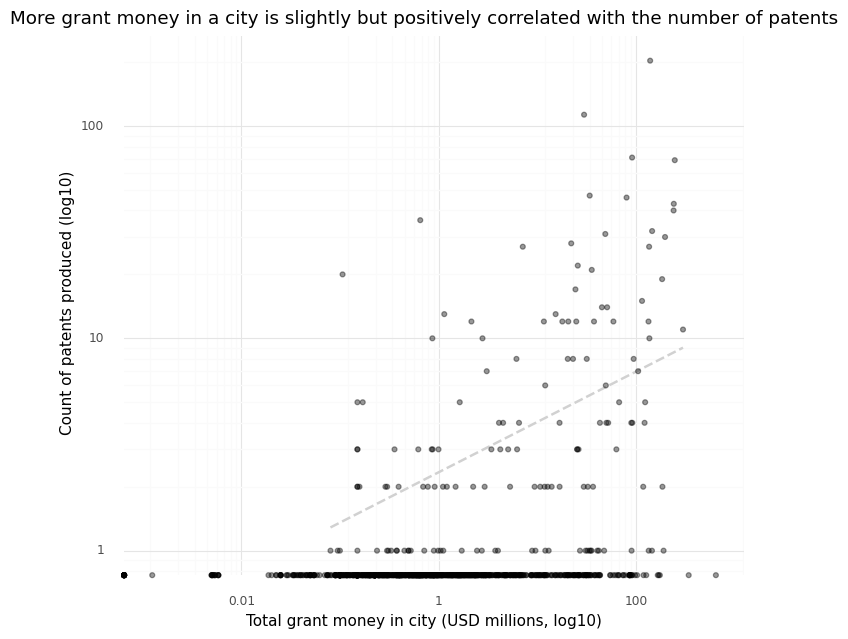

In [127]:
# convert grants to mm so its interpretable
city_summary_transformed = city_summary.copy(deep=True)
city_summary_transformed['grant_cost'] = city_summary_transformed.grant_cost / 1000000
fig = (ggplot(city_summary_transformed,
        aes(x='grant_cost', y='n_patents')) +
        geom_smooth(method='lm', se=False, linetype='dashed', color='#d1d1d1') +
        geom_point(alpha = 0.4) +
        scale_x_log10() +
        scale_y_log10() +
        labs(title="More grant money in a city is slightly but positively correlated with the number of patents",
             x='Total grant money in city (USD millions, log10)',
             y='Count of patents produced (log10)') +
        theme(figure_size=(8, 7))
    ).draw()
ax = fig.axes[0]
ax.collections[0].set_clip_on(False)

In [128]:
# fit simple linear regression
sm.ols(formula="n_patents ~ n_pis + grant_cost", data=city_summary_transformed).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              n_patents   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     66.64
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.36e-28
Time:                        22:02:56   Log-Likelihood:                -3977.7
No. Observations:                1136   AIC:                             7961.
Df Residuals:                    1133   BIC:                             7977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2731      0.255      1.069      0.285      -0.228       0.774
n_pis          0.0177      0.005      3.275      0.001       0.007       0.028
grant_cost     0.0470      0.011      4.394      0.000       0.026       0.068
==============================================================================
Omnibus:                     2258.636   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4739336.419
Skew:                          15.066   Prob(JB):                         0.00
Kurtosis:                     317.990   Cond. No.                         87.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Merge data for maps
We need latlong for each city so we can plot

In [103]:
# get ZIPs from grants data
grant_zips = []

for grant_file in all_grants:
    
    # read in the grant data
    grant_df = pd.read_csv(grant_file, index_col=None, header=0, skipinitialspace=True,
                           usecols=['ORGANIZATION_CITY', 'ORGANIZATION_STATE', 'ORGANIZATION_ZIP'])
    grant_df.columns = grant_df.columns.str.lower()
    
    # remove duplicates
    grant_df = grant_df.drop_duplicates()
    
    # append it to the results list
    grant_zips.append(grant_df)


# combine into one dataframe
zips_df = pd.concat(grant_zips, axis=0, ignore_index=True).drop_duplicates()

In [104]:
# rename columns
zips_df = zips_df.rename(columns={'organization_city': 'city', 'organization_state': 'state', 'organization_zip': 'ZIP'})

# clean up names and combine
zips_df['city'] = zips_df.city.apply(lambda x: str(x).title())
zips_df['city'] = zips_df.city + ", " + zips_df.state
zips_df = zips_df.drop(columns=["state"])

# clean up zip code
zips_df['ZIP'] = zips_df.ZIP.apply(lambda x: str(x)[:5])
zips_df

,city,ZIP
0,"Tucson, AZ",85719
1,"Brook Park, OH",44142
2,"Evanston, IL",60208
3,"Santa Cruz, CA",95064
4,"Irvine, CA",92697
...,...,...
59469,"Durham, NC",27713
59471,"Raleigh, NC",27609
59473,"Chicago, IL",60645
59480,"La Jolla, CA",92093


In [113]:
# read in dataset of zips with latlong
zip_latlong = pd.read_table('data/zip_latlong.csv', sep=";", usecols=['Zip', 'geopoint'])
zip_latlong = zip_latlong.rename(columns={'Zip': "ZIP"})
zip_latlong['ZIP'] = zip_latlong.ZIP.apply(lambda x: str(x))
zip_latlong

,ZIP,geopoint
0,38732,"33.749149,-90.71329"
1,47872,"39.758142,-87.1754"
2,50049,"41.02891,-93.29857"
3,48463,"43.167457,-83.52542"
4,51063,"42.137272,-96.16648"
...,...,...
43186,50157,"41.7388,-92.56155"
43187,65212,"38.937608,-92.33043"
43188,11935,"41.012868,-72.4723"
43189,63539,"39.893011,-92.74503"


In [123]:
# merge to get the lat/long by zip
city_locations = city_summary.merge(zips_df, how='left').merge(zip_latlong, how='left')

In [129]:
# retain only the first row per city
# this works because the city (not ZIP) is our unit of analysis and we're just using ZIP approximate
#   the lat/long position
city_locations = city_locations.groupby('city').first()
city_locations.sort_values('n_pis', ascending=False).reset_index()

# write out
city_locations.to_csv("data/city_locations.csv")

## Efficiency of converting green technology grants 

### Errors - what are the issues we ran into?
What is urban; what is rural
Researchers that moved universities
What is the potential consequences of these errors?

What selection error do we have? Who is missing from our frame?

What is our error structure?

When matching, we blocked on university name and PI so we may be missing when a researcher moves organizations